<a href="https://colab.research.google.com/github/brock-ricker/food_sales_predictions/blob/main/Food_Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sales Predictions

- Brock Ricker

- last update 03/31/2022

In [608]:
#Importing modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import plot_tree
set_config(display='diagram')

#Data importing and cleaning

In [609]:
#Importing Data
filepath = "https://raw.githubusercontent.com/brock-ricker/food_sales_predictions/main/sales_predictions.csv"
df = pd.read_csv(filepath)


In [610]:
#Initial Data Exploration

#Question 1
print(f"{df.shape[0]} rows and {df.shape[1]} columns")

#Question 2
print(df.info())

8523 rows and 12 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


In [611]:
#Dropping Duplicates

#Question 3 - finding # of duplicates
dups = df.duplicated()
print(pd.value_counts(dups))
#This is coming back as false (non-dupicates) = 8523, which is the same number of rows as original table, meaning there are no duplicates
#another way to check is to try dropping duplicates and then check the size of the resulting table
df = df.drop_duplicates()
df.info()
#same size as original, no duplicates

False    8523
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.6+ KB


In [612]:
#Question 7 addressing  inconsistent data
#Lets look at unique values for each column and see if there are any oddities. I will skip the item identifier, because I would not be able to spot inconsistincies in those
#First lets split into numerical data and object types.
df_ints = df.select_dtypes(include = ["int64","float64"])
pd.set_option('display.max_columns', None)
df_ints.describe()
#All of these numbers seem OK

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [613]:
#Question 7 addressing  inconsistent data cont. - categorical
df_obj = df.select_dtypes(include = "object")
df_obj = df_obj.drop(columns = "Item_Identifier")
df_obj_cols = list(df_obj)
for col in df_obj_cols:
  print(f"{col}: {df_obj[col].unique()}\n")
#only column with issues is fat content

Item_Fat_Content: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

Item_Type: ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier: ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size: ['Medium' nan 'High' 'Small']

Outlet_Location_Type: ['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type: ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [614]:
#fat content
#first lets create the replacement dict
fat_cont = {"low fat":"Low Fat",
            "LF":"Low Fat",
            "reg":"Regular"
            }

df["Item_Fat_Content"] = df["Item_Fat_Content"].replace(to_replace = fat_cont)

#and check it
print(df["Item_Fat_Content"].unique())
#looks good

['Low Fat' 'Regular']


In [615]:
#Filling in missing item weights.

#To fill these missing values, I want to see if I can get the pertinant information from other rows.
weights = df.groupby("Item_Identifier")["Item_Weight"].unique()
#skimming this series, looks like most items have at least 1 entry for weight, lets use those entries to fill in the blanks. Ill take the mean of each weight entry(per unique item), in case there are >1 non-blank. 
#To prevent data leakage I will only use weights from training set. So I haev to split them now.

#Defining test/train to replace weights. I will define again, once the 
X = df.drop(columns = "Item_Outlet_Sales")
y = df["Item_Outlet_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#This will, in effect, replace the blank item wieghts with the average weight of the same item.
weights = X_train.groupby("Item_Identifier")["Item_Weight"].mean().round(2)
#creating dictionairy out of these values
weight_replace = weights.to_dict()
#use this dictionairy to replace the null values
df["Item_Weight"] = df["Item_Weight"].fillna(df["Item_Identifier"].map(weight_replace))
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8496 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.6+ KB
None


#Exploratory Visualization


Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


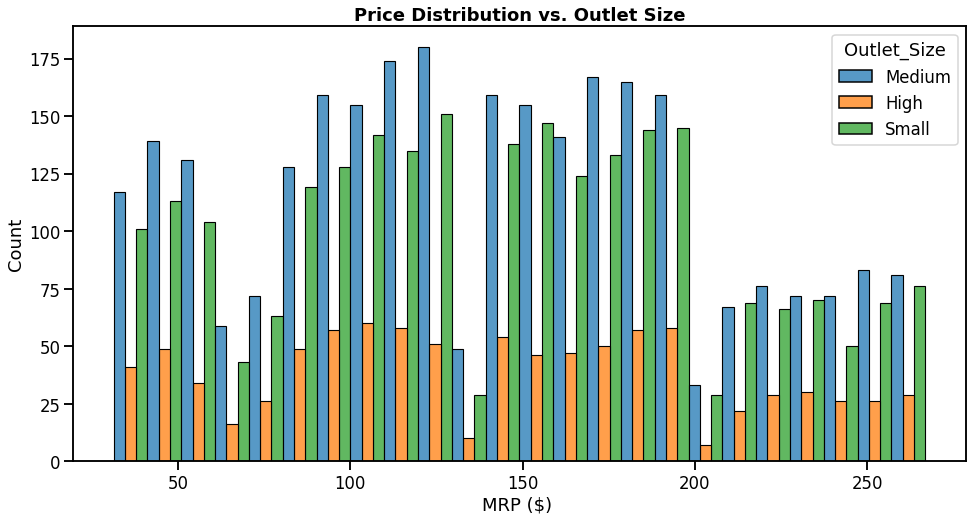

In [691]:
#Histogram
#Lets look at the distribution of prices for items, and see if the outlet size has any effect on the price of the items they carry
plt.figure(figsize = (16,8))
plot_hist = sns.histplot(data = df, x = "Item_MRP", hue = "Outlet_Size", multiple = "dodge")
plot_hist.set_title('Price Distribution vs. Outlet Size',fontsize = 18, fontweight='bold' )
plot_hist.set_xlabel('MRP ($) ', fontsize = 18)
plot_hist.set_ylabel('Count', fontsize = 18);
print(pd.value_counts(df["Outlet_Size"]))
#Looks like the distribution of prices is roughly equal, but there are not many stores in the "high" category, which is why the counts are smaller for each bin in that size category

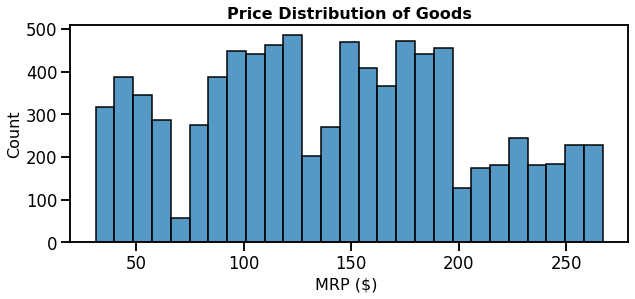

In [732]:
plt.figure(figsize = (10,4))
plot_hist = sns.histplot(data = df, x = "Item_MRP", multiple = "dodge")
plot_hist.set_title('Price Distribution of Goods',fontsize = 16, fontweight='bold' )
plot_hist.set_xlabel('MRP ($) ', fontsize = 16)
plot_hist.set_ylabel('Count', fontsize = 16);

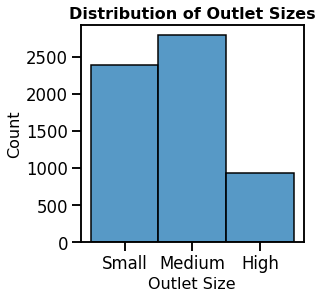

In [740]:
plt.figure(figsize = (4,4))
size_df = df.copy()
size_df["Outlet_Size"] = pd.Categorical(df["Outlet_Size"], ['Small','Medium','High'])
plot_hist = sns.histplot(data = size_df, x = "Outlet_Size")
plot_hist.set_title('Distribution of Outlet Sizes',fontsize = 16, fontweight='bold' )
plot_hist.set_xlabel('Outlet Size', fontsize = 16)
plot_hist.set_ylabel('Count', fontsize = 16);

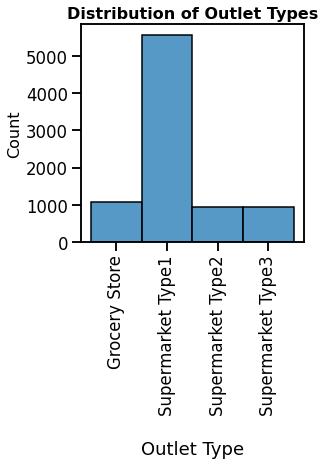

In [737]:

types=['Grocery Store','Supermarket Type1','Supermarket Type2','Supermarket Type3']
plt.figure(figsize = (4,4))
type_df = df.copy()
size_df["Outlet_Type"] = pd.Categorical(df["Outlet_Type"],types)
plot_hist = sns.histplot(data = size_df, x = "Outlet_Type")
plot_hist.set_title('Distribution of Outlet Types',fontsize = 16, fontweight='bold' )
plot_hist.set_xticklabels(types,rotation=90)
plot_hist.set_xlabel("\nOutlet Type")
plot_hist.set_ylabel('Count', fontsize = 16);

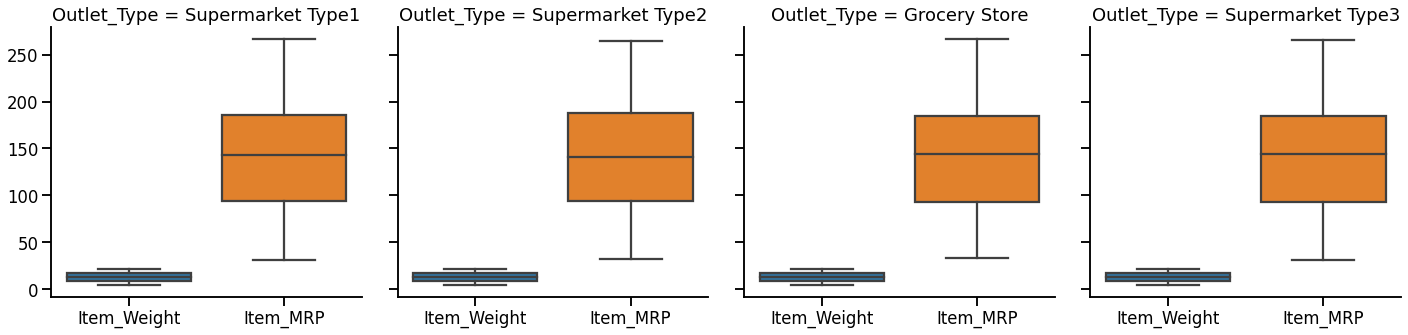

In [617]:
#Boxplot
#Now lets try using boxplots to compare different items info accross different outlet types
df_item_info = df[["Item_Weight","Item_MRP","Outlet_Type"]]
plot_box = sns.catplot(data=df_item_info, col="Outlet_Type", kind="box")
#This is actually better for distribution comparison, because boxplots show sumamry statistics instead of counts.
#the distribution of items prices and weights accross the different store types is very similar

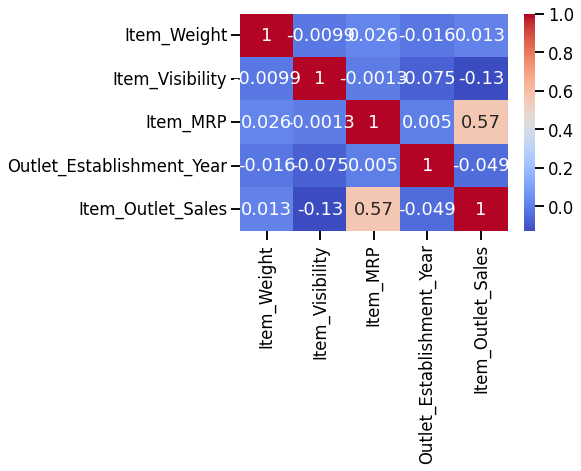

In [618]:
#Heatmap
corr = df.corr()
sns.heatmap(corr, cmap = "coolwarm", annot = True);
#Interesting, looks like there is a correlation between item MRP, and sales ($) makes sense, more expensive items make the store more money

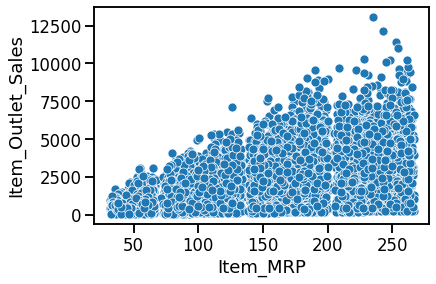

In [619]:
#Lets look at that relationship
sns.scatterplot(data=df, x = "Item_MRP", y = "Item_Outlet_Sales");
#looks like the the price of an item, determines an upper bound of how much money a store can make on that specific item. This makes sense.

#Explanatory Visialization



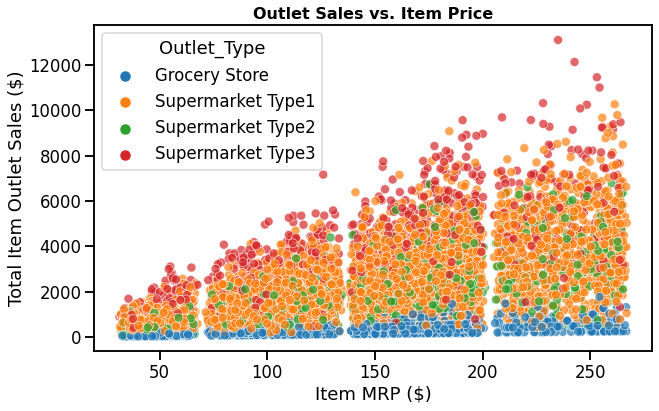

In [744]:
#Lets further explore the trend we found in the previous section
fig, ax = plt.subplots(figsize=(10,6))
sns.set_context('talk')
scatter = sns.scatterplot(data=df, x = "Item_MRP", y = "Item_Outlet_Sales",hue = "Outlet_Type", hue_order = ['Grocery Store','Supermarket Type1','Supermarket Type2','Supermarket Type3'], ax=ax,alpha=0.7)
scatter.set_title('Outlet Sales vs. Item Price',fontsize = 16, fontweight='bold' )
ax.set_xlabel("Item MRP ($)")
ax.set_ylabel("Total Item Outlet Sales ($)");

In [621]:
#looks like there is some difference in the amount of items each store type sells, but it is difficult to tell with them graphed on top of each other. Lets turn this plot into a function and split them up.
def sales_plot(dataframe,outlet_type):
  df_active = dataframe.loc[dataframe["Outlet_Type"]==outlet_type]
  fig, ax = plt.subplots(figsize=(12,6));
  ax.set(title=f'Item Sales($) vs. Item Price for {outlet_type}');
  sns.set_context('talk');
  ax.set_xlim(left=0,right=275)
  ax.set_xlabel("Item MRP ($)")
  ax.set_ylim(bottom=0,top=13000)
  ax.set_ylabel("Total Item Outlet Sales ($)")
  sns.scatterplot(data=df_active, x = "Item_MRP", y = "Item_Outlet_Sales", hue = "Outlet_Identifier",ax=ax);
  return fig,ax


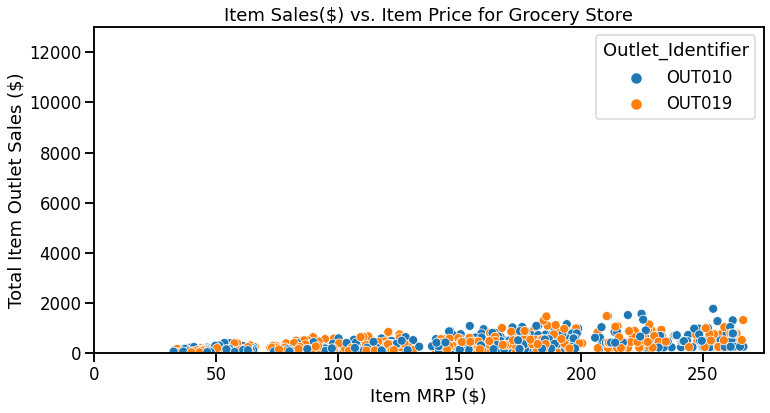

In [622]:
fig, ax = sales_plot(df,"Grocery Store")

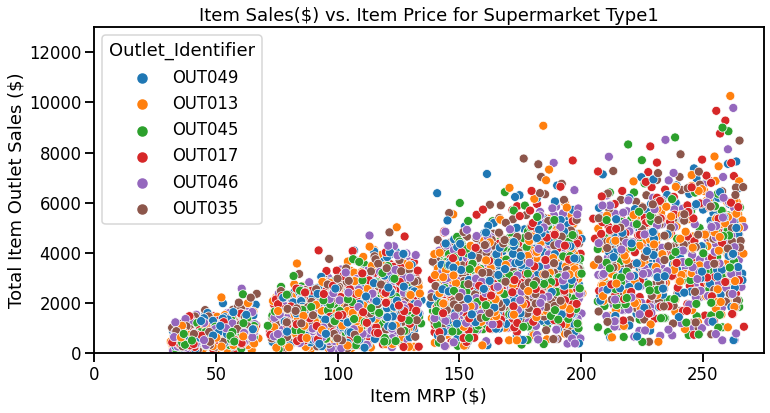

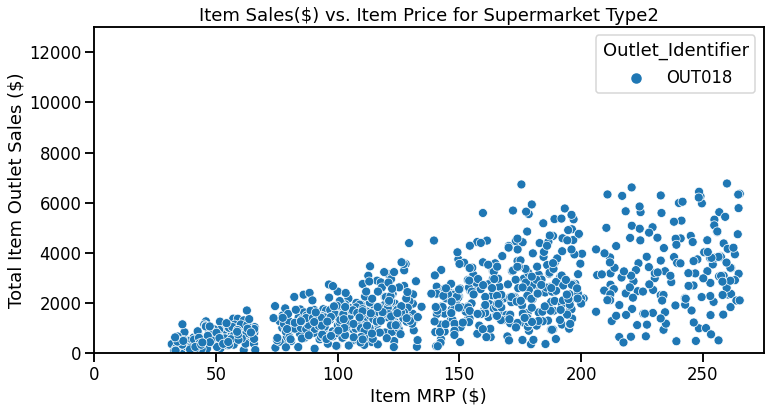

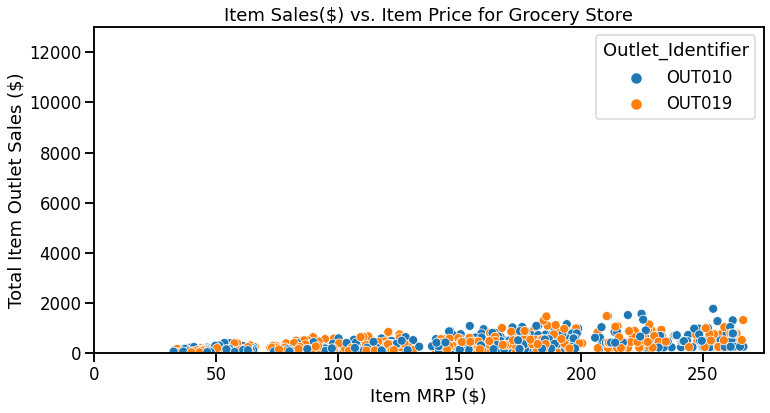

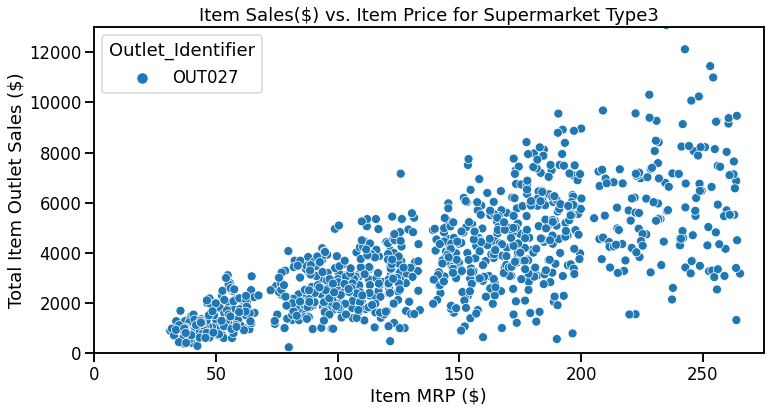

In [623]:
types = df["Outlet_Type"].unique()

for out_type in types:
  fig, ax = sales_plot(df,out_type)

#Looks like there is a relationship between outlet type and how much money they earn from certain products. This makes sense as the supermarkets do more volume thatn grocery stores.

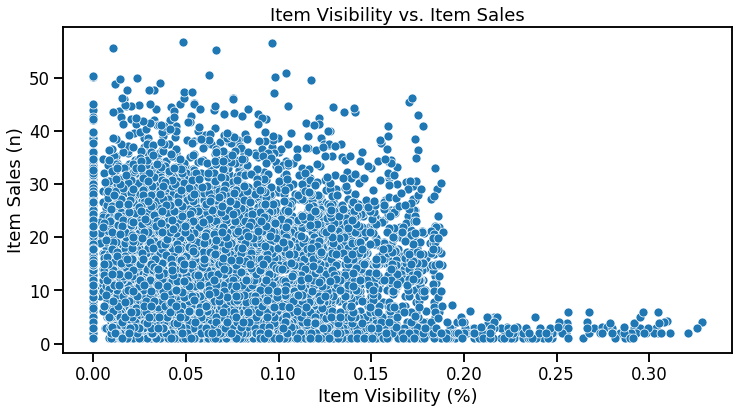

In [624]:

#Looks like the Item_Outlet_Sales is in amount of money, so lets calculate the number of items sold and analyze that. I will create a new dataframe for this, so it does not affect my model later

df_temp = df.copy()
df_temp["Number_Of_Item_Outlet_Sales"] = df_temp["Item_Outlet_Sales"]/df_temp["Item_MRP"]



fig, ax = plt.subplots(figsize=(12,6));
ax.set(title='Item Visibility vs. Item Sales');
sns.set_context('talk');
ax.set_xlabel("Item Visibility (%)");
ax.set_ylabel("Item Sales (n)");
sns.scatterplot(data = df_temp, x = "Item_Visibility", y="Number_Of_Item_Outlet_Sales");

#Looks like there is a weak negative correlation between visibility and # of items sold. This is probably because they make bad selling items more visible in an attempt to sell more.

#Data Pre-processing

In [625]:
#Defining Features and Target

#I will drop the Item identifier, since there are so many unique items
X = df.drop(columns = ["Item_Outlet_Sales","Item_Identifier"])
y = df["Item_Outlet_Sales"]

In [626]:
#There are several columns that are ordinal, these need to be recoded before I can move on.

df["Item_Fat_Content"].replace({"Low Fat":0,"Regular":1}, inplace = True)

#for this one, I am making the assumption that tier 1 = best location type and tier 3 = worst
df["Outlet_Location_Type"].replace({'Tier 3':0 ,'Tier 2':1, 'Tier 1':2}, inplace = True)

#Outlet size is also ordinal, but it has missing values, and there is no numerical equivalent of "missing" so I am going to impute/encode that column instead

In [627]:
#creating train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [628]:
#In order to prevent data leakage, I removed the portion of my previous code that filled in missing values, instead I will use simple imputer.

#instantiate imputers
mean_imputer = SimpleImputer(strategy = "mean")
cons_imputer = SimpleImputer(strategy = "constant", fill_value = "unknown")


In [629]:
#creating column selectors
cat_column_selector = make_column_selector(dtype_include = "object")
num_column_selector = make_column_selector(dtype_include = "number")

In [630]:
#instantiate encoder
encoder = OneHotEncoder(sparse = False, handle_unknown = "ignore")

In [631]:
#instantiate scaler
scaler = StandardScaler()

In [632]:
#creating pipelines
num_pipeline=make_pipeline(mean_imputer,scaler)
cat_pipeline=make_pipeline(cons_imputer,encoder)

In [633]:
#create tuples for column transformer  - For the linear regression model, scaling is needed, for decision trees it is not. However, it will no negatively affect the outcome. So I will scale for both methods to simplify the code.
num_tuple = (num_pipeline, num_column_selector)
cat_tuple = (cat_pipeline, cat_column_selector)

In [634]:
#create column transformer
col_transformer = make_column_transformer(num_tuple_scaled,cat_tuple,remainder="passthrough")

In [635]:
#fitting column transformers
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff33162ac50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff324462350>)])

In [636]:
#transforming our data
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

In [637]:
#I want to get column names from my model, this will be useful when I am evaluating the model

#getting column names from our data sets
cat_feature_names = col_transformer.named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names_out(cat_column_selector(X_train))
final_cols = num_column_selector(X_train) + list(cat_feature_names)

#Adding back to dataset
X_train_processed = pd.DataFrame(X_train_processed, columns = final_cols)
X_test_processed = pd.DataFrame(X_test_processed, columns = final_cols)

In [638]:
#Building Function to evaluate all models - this will be used later
def eval_model(true,pred):
  r2 = r2_score(true,pred)
  mae = mean_absolute_error(true,pred)
  mse = mean_squared_error(true,pred)
  rmse = np.sqrt(mse)
  print(f" R2: {r2:,.4f} \n MAE: {mae:,.2f} \n MSE: {mse:,.2f} \n RMSE: {rmse:,.2f}")

#Linear Regression Modeling




In [639]:
#Instantiate model
reg = LinearRegression()

In [640]:
#Fit the model on transformed data
reg.fit(X_train_processed,y_train)

LinearRegression()

In [641]:
#Evaluating Fit
print("Training set model evaluation metrics:")
eval_model(reg.predict(X_train_processed),y_train)

print("\nTest set model evaluation metrics:")
eval_model(reg.predict(X_test_processed),y_test)

#Interestingly enough, the model fits the test set better than the training set. But both models are very poor (<30% prediction). They are able to predict the outlet sales within ~$1000

Training set model evaluation metrics:
 R2: 0.2192 
 MAE: 847.10 
 MSE: 1,297,568.04 
 RMSE: 1,139.11

Test set model evaluation metrics:
 R2: 0.2856 
 MAE: 804.08 
 MSE: 1,194,361.28 
 RMSE: 1,092.87


In [642]:
#Making a datframe of the linear fit coefficients. The larger numbers in this case are items that affect the sales more this might be useful for exploration later
linear_coefficients = pd.DataFrame()
linear_coefficients["Feature"] = np.array(final_cols)
linear_coefficients["Coefficient"] = reg.coef_
linear_coefficients

,Feature,Coefficient
0,Item_Weight,-7.540534e+00
1,Item_Visibility,-2.164702e+01
2,Item_MRP,9.845336e+02
3,Outlet_Establishment_Year,-5.790367e+13
4,Item_Fat_Content_Low Fat,5.443176e+13
5,Item_Fat_Content_Regular,5.443176e+13
6,Item_Type_Baking Goods,-5.782175e+12
7,Item_Type_Breads,-5.782175e+12
8,Item_Type_Breakfast,-5.782175e+12
9,Item_Type_Canned,-5.782175e+12


#Decision Tree Modeling


In [644]:
#instantiate the decision tree
dec_tree = DecisionTreeRegressor(random_state=42)

In [645]:
#fit the tree
dec_tree.fit(X_train_processed,y_train)

DecisionTreeRegressor(random_state=42)

In [646]:
#getting default depth
print("default depth of tree:",dec_tree.get_depth())

default depth of tree: 40


In [647]:
#evaluate the fit
print("R2 of training data using default tree depth:", dec_tree.score(X_train_processed,y_train))
print("R2 of test data using default tree depth:", dec_tree.score(X_test_processed,y_test))

R2 of training data using default tree depth: 1.0
R2 of test data using default tree depth: 0.1882152181629878


This is model is WAY overfit. We will need to optimize it

In [648]:
depths = list(range(2,50))

best_depth = 0
r2_test = 0
r2_train = 0

for depth in depths:
  dec_tree=DecisionTreeRegressor(max_depth=depth, random_state=42)
  dec_tree.fit(X_train_processed,y_train)
  r2_temp = dec_tree.score(X_test_processed,y_test)
  if r2_temp > r2_test:
    r2_test=r2_temp
    r2_train = dec_tree.score(X_train_processed,y_train)
    best_depth = depth

print(f"the optimal depth is: {best_depth}, resulting in an R2 score of: {r2_test:,.6f} on the test set, and a R2 score of: {r2_train:,.6f} on the training set") 

the optimal depth is: 5, resulting in an R2 score of: 0.595022 on the test set, and a R2 score of: 0.603903 on the training set


Looks like the fitting is much imrpoved now.

In [649]:
#Building final decision tree model
dec_tree = DecisionTreeRegressor(random_state=42,max_depth=best_depth)
dec_tree.fit(X_train_processed,y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

#Comparison of Models

In [651]:
print("Training Scores for Decision Tree")
eval_model(y_train,dec_tree.predict(X_train_processed))
print("---")
print("Test Scores for Decision Tree")
eval_model(y_test,dec_tree.predict(X_test_processed))
print("\n")
print("Training Scores for Linear Regression Model")
eval_model(y_train,reg.predict(X_train_processed))
print("---")
print("Test Scores for Linear Regression Model")
eval_model(y_test,reg.predict(X_test_processed))

Training Scores for Decision Tree
 R2: 0.6039 
 MAE: 762.76 
 MSE: 1,172,230.06 
 RMSE: 1,082.70
---
Test Scores for Decision Tree
 R2: 0.5950 
 MAE: 737.63 
 MSE: 1,117,324.23 
 RMSE: 1,057.04


Training Scores for Linear Regression Model
 R2: 0.5616 
 MAE: 847.10 
 MSE: 1,297,568.04 
 RMSE: 1,139.11
---
Test Scores for Linear Regression Model
 R2: 0.5671 
 MAE: 804.08 
 MSE: 1,194,361.28 
 RMSE: 1,092.87


Both models do a mediocre job of predicting item sales. But the Decision tree is superior, able to predcit ~60% of the outcomes, with a RMSE of $1057 on the test set.

The linear regression model is able to predict ~56% of the outcomes, with an RMSE of $1092 on the test set.

I would reccomend using the decision tree model, because it outperforms on every metric

#Prediction of sales

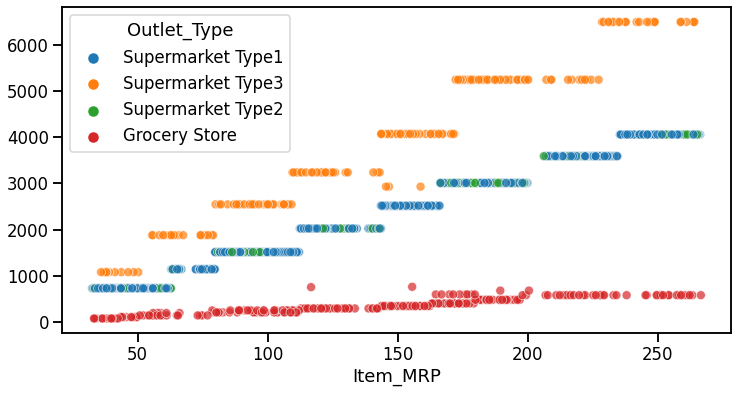

In [673]:
#Use Decision tree to predict sales based on outlet type and MRP
fig, ax = plt.subplots(figsize=(12,6))
sns.set_context('talk')
sns.scatterplot(x = X_test["Item_MRP"], y = dec_tree.predict(X_test_processed) ,hue = X_test["Outlet_Type"], ax=ax,alpha=0.7);
#not much insight here, Considering I don't know the details of the store types

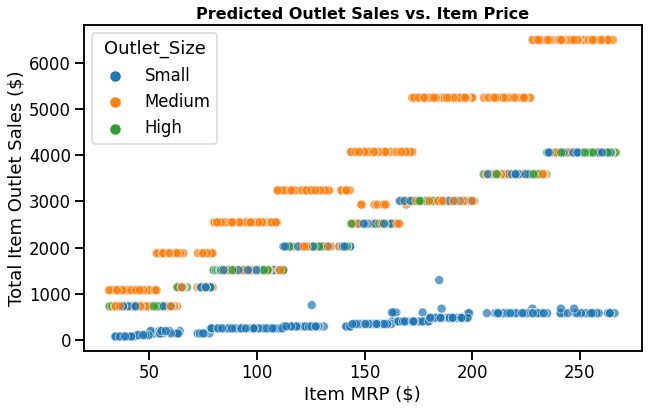

In [747]:
#Use Decision tree to predict sales based on outlet size and item price
fig, ax = plt.subplots(figsize=(10,6))
sns.set_context('talk')
ax.set_xlabel("Item MRP ($)")
ax.set_ylabel("Total Item Outlet Sales ($)")
ax.set_title('Predicted Outlet Sales vs. Item Price',fontsize = 16, fontweight='bold' )
sns.scatterplot(x = X_train["Item_MRP"], y = dec_tree.predict(X_train_processed) ,hue = X_train["Outlet_Size"], hue_order=["Small","Medium","High"], ax=ax,alpha=0.7);

This graph is insightful, from it I can say the following:
*medium stores make the most outlet sales
*small stores make the least
*The difference is biggest with high priced Items

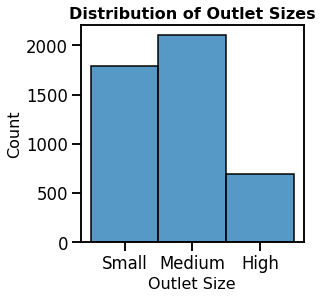

In [749]:
#Outlet Size distribution included in prediction data set
plt.figure(figsize = (4,4))
size_df = X_train.copy()
size_df["Outlet_Size"] = pd.Categorical(size_df["Outlet_Size"], ['Small','Medium','High'])
plot_hist = sns.histplot(data = size_df, x = "Outlet_Size")
plot_hist.set_title('Distribution of Outlet Sizes',fontsize = 16, fontweight='bold' )
plot_hist.set_xlabel('Outlet Size', fontsize = 16)
plot_hist.set_ylabel('Count', fontsize = 16);

This size distribution supports my previous assertions, and shows that the difference in sales is  not purely based on the number of items